In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from glob import glob
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load and Merge CSV Files ---
folder_path = '/content/drive/MyDrive/data_5drivers/'

# Get all CSV files in the folder
all_files = glob(os.path.join(folder_path, "*.csv"))

# List to hold DataFrames from each file
df_list = []

for file in all_files:
    df = pd.read_csv(file)

    # Ensure the 'plate' column exists
    if 'plate' in df.columns:
        df_list.append(df)

# Merge all CSV files into one DataFrame
merged_df = pd.concat(df_list, ignore_index=True)

# --- Step 2: Find Maximum Trajectory Length ---
trajectory_counts = merged_df.groupby('plate').size()
max_trajectory_length = trajectory_counts.max()
print(f"Maximum trajectory length: {max_trajectory_length}")

# --- Step 3: Limit Each Driver's Trajectory ---
balanced_df = merged_df.groupby('plate').apply(lambda x: x.head(max_trajectory_length)).reset_index(drop=True)

# --- Step 4: Separate Features and Labels ---
features = balanced_df[['longitude', 'latitude', 'time']]
labels = balanced_df['status']

# --- Step 5: Feature Engineering ---
# Z-standardization
scaler = StandardScaler()
balanced_df[['longitude', 'latitude']] = scaler.fit_transform(balanced_df[['longitude', 'latitude']])

# Convert 'time' to datetime
balanced_df['time'] = pd.to_datetime(balanced_df['time'], errors='coerce')

# Extract time components
balanced_df['month'] = balanced_df['time'].dt.month
balanced_df['day'] = balanced_df['time'].dt.day
balanced_df['week'] = balanced_df['time'].dt.isocalendar().week
balanced_df['hour'] = balanced_df['time'].dt.hour
balanced_df['minute'] = balanced_df['time'].dt.minute
balanced_df['second'] = balanced_df['time'].dt.second

# Cyclical encoding
balanced_df['month_sin'] = np.sin(2 * np.pi * balanced_df['month'] / 12)
balanced_df['month_cos'] = np.cos(2 * np.pi * balanced_df['month'] / 12)
balanced_df['day_sin'] = np.sin(2 * np.pi * balanced_df['day'] / 31)
balanced_df['day_cos'] = np.cos(2 * np.pi * balanced_df['day'] / 31)
balanced_df['week_sin'] = np.sin(2 * np.pi * balanced_df['week'] / 52)
balanced_df['week_cos'] = np.cos(2 * np.pi * balanced_df['week'] / 52)
balanced_df['hour_sin'] = np.sin(2 * np.pi * balanced_df['hour'] / 24)
balanced_df['hour_cos'] = np.cos(2 * np.pi * balanced_df['hour'] / 24)
balanced_df['minute_sin'] = np.sin(2 * np.pi * balanced_df['minute'] / 60)
balanced_df['minute_cos'] = np.cos(2 * np.pi * balanced_df['minute'] / 60)
balanced_df['second_sin'] = np.sin(2 * np.pi * balanced_df['second'] / 60)
balanced_df['second_cos'] = np.cos(2 * np.pi * balanced_df['second'] / 60)

# Drop the original 'time' and intermediate time columns
balanced_df = balanced_df.drop(columns=['time', 'month', 'day', 'week', 'hour', 'minute', 'second'])

# Convert all relevant columns to numeric to avoid object types
for col in balanced_df.columns:
    balanced_df[col] = balanced_df[col].astype(float)

# Drop rows with NaN values resulting from conversion
balanced_df = balanced_df.dropna()

# Optional: Print a sample of the DataFrame for debugging
print(balanced_df.sample(5))  # View 5 random rows

# Verify the data types before conversion
print(balanced_df.dtypes)

# --- Step 6: Prepare Data for PyTorch ---
# Convert features and labels to PyTorch tensors
features_tensor = torch.tensor(balanced_df[['longitude', 'latitude', 'month_sin', 'month_cos',
                                              'day_sin', 'day_cos', 'week_sin', 'week_cos',
                                              'hour_sin', 'hour_cos', 'minute_sin',
                                              'minute_cos', 'second_sin', 'second_cos']].values,
                                dtype=torch.float32)

labels_tensor = torch.tensor(balanced_df['status'].values, dtype=torch.float32)  # Adjust dtype based on label type

# Check shapes
print("Features shape:", features_tensor.shape)
print("Labels shape:", labels_tensor.shape)

# Create TensorDataset
dataset = TensorDataset(features_tensor, labels_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)  # Set batch size to 20
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)  # Set batch size to 20

<ipython-input-47-69931416df55>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(df_list, ignore_index=True)


Maximum trajectory length: 1014370


<ipython-input-47-69931416df55>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = merged_df.groupby('plate').apply(lambda x: x.head(max_trajectory_length)).reset_index(drop=True)


         plate  longitude  latitude  status  month_sin     month_cos  \
429349     0.0   0.141312 -0.003854     1.0  -0.866025  5.000000e-01   
1588017    1.0   0.012103 -0.004622     0.0  -0.866025  5.000000e-01   
3163123    3.0  -0.017565 -0.005173     0.0  -0.866025  5.000000e-01   
505246     0.0  -0.515679  0.001860     1.0  -0.500000 -8.660254e-01   
3346210    3.0   0.152802 -0.000618     1.0  -1.000000 -1.836970e-16   

          day_sin   day_cos  week_sin  week_cos      hour_sin  hour_cos  \
429349  -0.968077 -0.250653 -0.935016  0.354605 -7.071068e-01 -0.707107   
1588017 -0.571268  0.820763 -0.885456  0.464723  1.224647e-16 -1.000000   
3163123 -0.724793  0.688967 -0.885456  0.464723  9.659258e-01 -0.258819   
505246   0.897805 -0.440394 -0.120537 -0.992709  2.588190e-01 -0.965926   
3346210 -0.485302 -0.874347 -0.970942 -0.239316 -7.071068e-01  0.707107   

         minute_sin  minute_cos  second_sin    second_cos  
429349    -0.207912   -0.978148    1.000000  2.832769e-1

In [ ]:
import torch
import torch.nn as nn

# --- BaseModel using 15 inputs and multiple hidden layers ---
class BaseModel(nn.Module):
    def __init__(self, input_size=15):  # Set input size to 15
        super(BaseModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),  # Increased hidden layer size
            nn.ReLU(),
            nn.Linear(128, 64),  # Added additional hidden layer with 64 units
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),  # Final hidden layer before output
            nn.ReLU(),
            nn.Linear(16, 5),  # Assuming 5 classes for classification
            nn.Dropout(0.2)  # Dropout for regularization
        )

    def forward(self, x):
        return self.fc(x)

# --- RNNModel using 15 inputs and multiple hidden layers ---
class RNNModel(nn.Module):
    def __init__(self, input_size=15, num_layers=2):  # Set input size to 15 and num_layers to 2
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size=64, num_layers=num_layers, dropout=0.2, batch_first=True)  # Increased hidden size to 64
        self.fc = nn.Sequential(
            nn.Linear(64, 32),  # Hidden layer with 32 units
            nn.ReLU(),
            nn.Linear(32, 16),  # Final hidden layer before output
            nn.ReLU(),
            nn.Linear(16, 5),  # Assuming 5 classes for classification
            nn.Dropout(0.1)  # Dropout for regularization
        )

    def forward(self, x):
        x, _ = self.rnn(x)  # Get RNN output
        return self.fc(x[:, -1, :])  # Use the output of the last time step


# --- Instantiate the models ---
base_model = BaseModel(input_size=15)
rnn_model = RNNModel(input_size=15, num_layers=2)

# --- Print the network structure ---
print("BaseModel Structure:")
print(base_model)

print("\nRNNModel Structure:")
print(rnn_model)


BaseModel Structure:
BaseModel(
  (fc): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=5, bias=True)
    (9): Dropout(p=0.2, inplace=False)
  )
)

RNNModel Structure:
RNNModel(
  (rnn): RNN(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=5, bias=True)
    (5): Dropout(p=0.1, inplace=False)
  )
)


In [ ]:
import torch.optim as optim
import pickle

# Check the shape of features tensor
print("Features tensor shape:", features_tensor.shape)

# Initialize the model
model = BaseModel(input_size=features_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and Validation Loop
num_epochs = 10  # Set your number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0

    # Training loop
    for features, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, labels.long())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / len(train_loader.dataset)

    # Append training loss and accuracy to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)  # Forward pass
            loss = criterion(outputs, labels.long())  # Calculate loss
            val_loss += loss.item()

            # Calculate accuracy for validation
            _, predicted_val = torch.max(outputs.data, 1)
            correct_val += (predicted_val == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)

    # Append validation loss and accuracy to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print statistics for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

# Save the trained model in .pth format
torch.save(model.state_dict(), '/content/drive/MyDrive/trained_model.pth')
print("Model saved as .pth file.")

# Save the trained model in .pkl format
with open('/content/drive/MyDrive/trained_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)
print("Model saved as .pkl file.")

print("Model training complete and saved in both formats.")


Features tensor shape: torch.Size([4187013, 14])
Epoch [1/10], Train Loss: 0.7963, Train Accuracy: 0.5888, Val Loss: 0.6258, Val Accuracy: 0.6335
Epoch [2/10], Train Loss: 0.8238, Train Accuracy: 0.6007, Val Loss: 0.6187, Val Accuracy: 0.6413
Epoch [3/10], Train Loss: 1.0155, Train Accuracy: 0.6053, Val Loss: 0.6149, Val Accuracy: 0.6446
Epoch [4/10], Train Loss: 0.9285, Train Accuracy: 0.6088, Val Loss: 0.6112, Val Accuracy: 0.6469
Epoch [5/10], Train Loss: 1.1705, Train Accuracy: 0.6110, Val Loss: 0.6086, Val Accuracy: 0.6511
Epoch [6/10], Train Loss: 1.1479, Train Accuracy: 0.6134, Val Loss: 0.6060, Val Accuracy: 0.6536
Epoch [7/10], Train Loss: 1.9641, Train Accuracy: 0.6155, Val Loss: 0.6036, Val Accuracy: 0.6549
Epoch [8/10], Train Loss: 1.3164, Train Accuracy: 0.6170, Val Loss: 0.6040, Val Accuracy: 0.6564
Epoch [9/10], Train Loss: 1.9744, Train Accuracy: 0.6181, Val Loss: 0.6034, Val Accuracy: 0.6569
Epoch [10/10], Train Loss: 1.6969, Train Accuracy: 0.6184, Val Loss: 0.6023, V

In [ ]:
import torch.optim as optim
import pickle

# Check the shape of features tensor
print("Features tensor shape:", features_tensor.shape)

# Initialize the RNN model
rnn_model = RNNModel(input_size=features_tensor.shape[1])  # Adjust as needed

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Initialize lists to store losses and accuracies
rnn_train_losses = []
rnn_val_losses = []
rnn_train_accuracies = []
rnn_val_accuracies = []

# Training and Validation Loop for RNN
num_epochs = 10  # Set your number of epochs

for epoch in range(num_epochs):
    rnn_model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0

    # Training loop
    for features, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = rnn_model(features.unsqueeze(1))  # Forward pass with unsqueezing if needed
        loss = criterion(outputs, labels.long())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / len(train_loader.dataset)

    # Append training loss and accuracy to the lists
    rnn_train_losses.append(avg_train_loss)
    rnn_train_accuracies.append(train_accuracy)

    # Validation loop
    rnn_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for features, labels in val_loader:
            outputs = rnn_model(features.unsqueeze(1))  # Forward pass
            loss = criterion(outputs, labels.long())  # Calculate loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)

    # Append validation loss and accuracy to the lists
    rnn_val_losses.append(avg_val_loss)
    rnn_val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"RNN Train Loss: {avg_train_loss:.4f}, RNN Train Accuracy: {train_accuracy:.4f}, "
          f"RNN Val Loss: {avg_val_loss:.4f}, RNN Val Accuracy: {val_accuracy:.4f}")

# Save the trained RNN model in .pth format
torch.save(rnn_model.state_dict(), '/content/drive/MyDrive/rnn_trained_model.pth')
print("RNN model saved as .pth file.")

# Save the trained RNN model in .pkl format
with open('/content/drive/MyDrive/rnn_trained_model.pkl', 'wb') as f:
    pickle.dump(rnn_model.state_dict(), f)
print("RNN model saved as .pkl file.")

print("RNN model training complete and saved in both formats.")

Features tensor shape: torch.Size([4187013, 14])
Epoch [1/10], RNN Train Loss: 0.7148, RNN Train Accuracy: 0.5961, RNN Val Loss: 0.6303, RNN Val Accuracy: 0.6279
Epoch [2/10], RNN Train Loss: 0.7054, RNN Train Accuracy: 0.6083, RNN Val Loss: 0.6252, RNN Val Accuracy: 0.6340
Epoch [3/10], RNN Train Loss: 0.7029, RNN Train Accuracy: 0.6109, RNN Val Loss: 0.6235, RNN Val Accuracy: 0.6349
Epoch [4/10], RNN Train Loss: 0.7018, RNN Train Accuracy: 0.6117, RNN Val Loss: 0.6229, RNN Val Accuracy: 0.6364
Epoch [5/10], RNN Train Loss: 0.7010, RNN Train Accuracy: 0.6128, RNN Val Loss: 0.6224, RNN Val Accuracy: 0.6377
Epoch [6/10], RNN Train Loss: 0.7001, RNN Train Accuracy: 0.6134, RNN Val Loss: 0.6200, RNN Val Accuracy: 0.6379
Epoch [7/10], RNN Train Loss: 0.7001, RNN Train Accuracy: 0.6134, RNN Val Loss: 0.6193, RNN Val Accuracy: 0.6390
Epoch [8/10], RNN Train Loss: 0.6994, RNN Train Accuracy: 0.6142, RNN Val Loss: 0.6192, RNN Val Accuracy: 0.6390
Epoch [9/10], RNN Train Loss: 0.6994, RNN Train

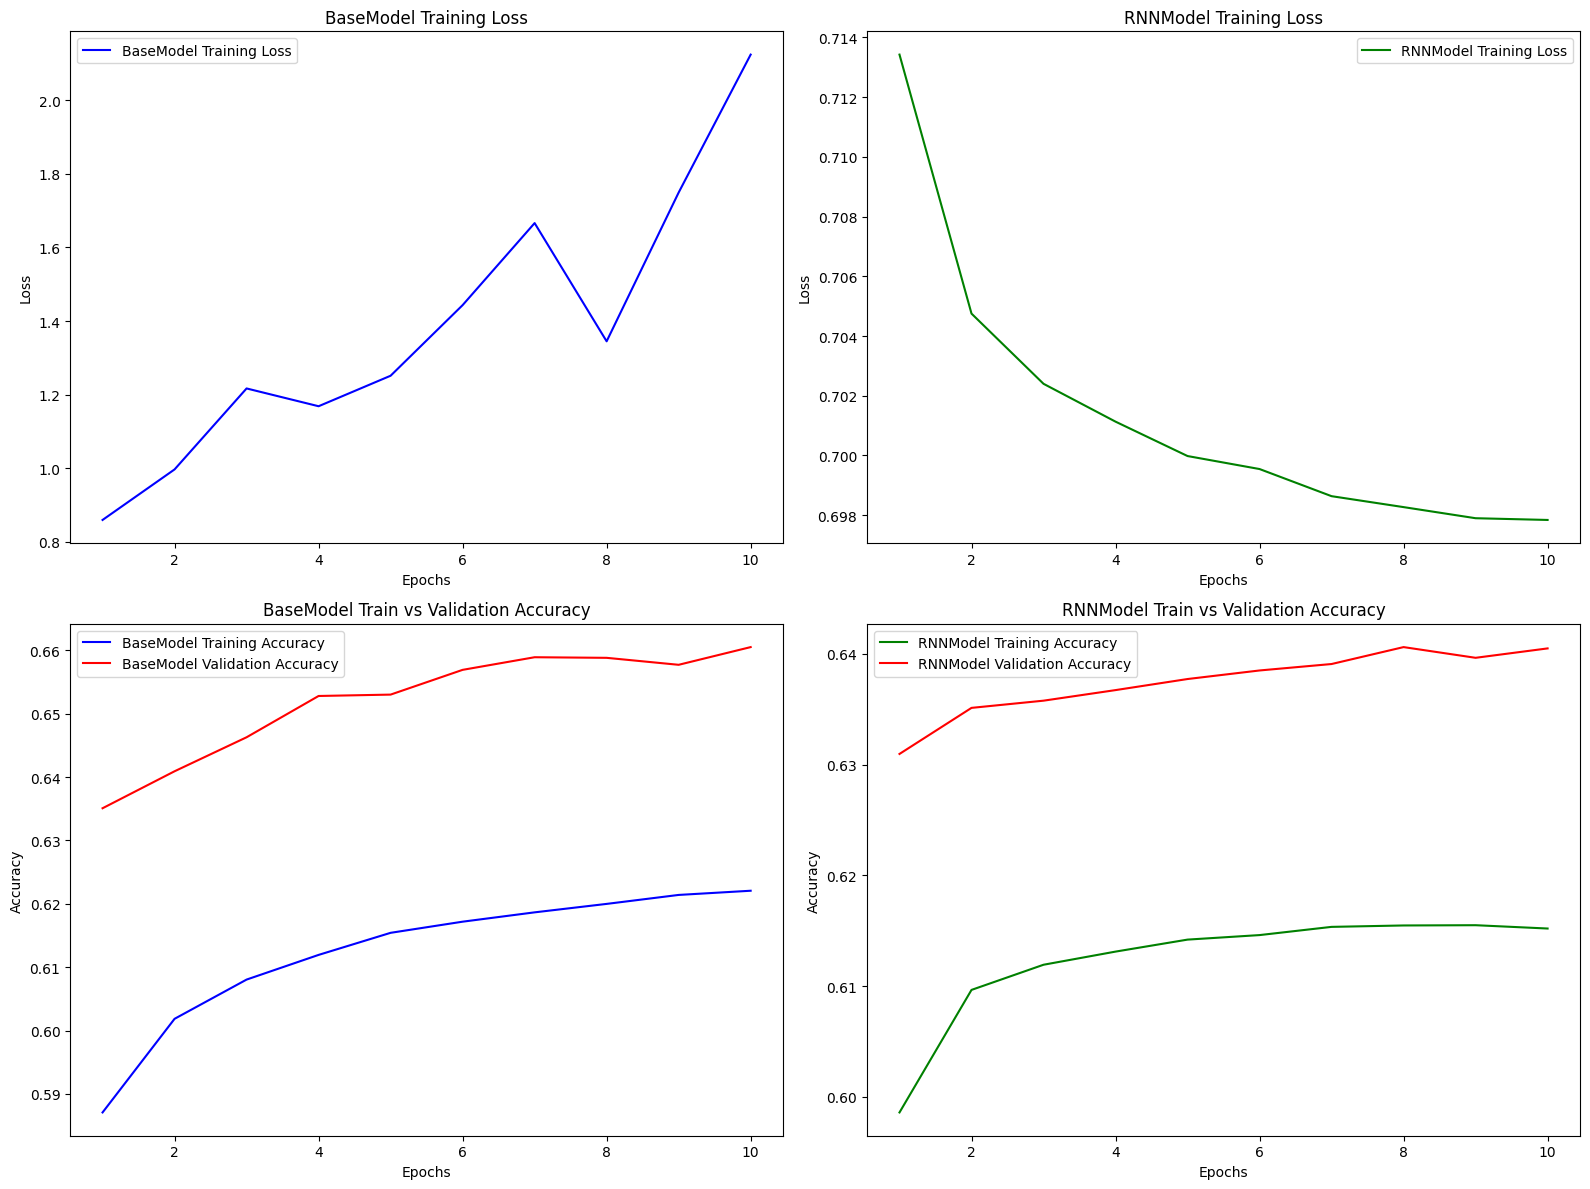

In [ ]:
import matplotlib.pyplot as plt

# Enhanced plot function for comparison between BaseModel and RNNModel
def plot_comparison(base_train_losses, base_val_losses, base_train_accuracies, base_val_accuracies,
                    rnn_train_losses, rnn_val_losses, rnn_train_accuracies, rnn_val_accuracies):

    epochs = range(1, len(base_train_losses) + 1)

    plt.figure(figsize=(16, 12))

    # Plot Training Loss for BaseModel
    plt.subplot(2, 2, 1)
    plt.plot(epochs, base_train_losses, 'b', label='BaseModel Training Loss')
    plt.title('BaseModel Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Loss for RNNModel
    plt.subplot(2, 2, 2)
    plt.plot(epochs, rnn_train_losses, 'g', label='RNNModel Training Loss')
    plt.title('RNNModel Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Train vs Validation Accuracy for BaseModel
    plt.subplot(2, 2, 3)
    plt.plot(epochs, base_train_accuracies, 'b', label='BaseModel Training Accuracy')
    plt.plot(epochs, base_val_accuracies, 'r', label='BaseModel Validation Accuracy')
    plt.title('BaseModel Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Train vs Validation Accuracy for RNNModel
    plt.subplot(2, 2, 4)
    plt.plot(epochs, rnn_train_accuracies, 'g', label='RNNModel Training Accuracy')
    plt.plot(epochs, rnn_val_accuracies, 'r', label='RNNModel Validation Accuracy')
    plt.title('RNNModel Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the comparison plot function
plot_comparison(train_losses, val_losses, train_accuracies, val_accuracies,
                rnn_train_losses, rnn_val_losses, rnn_train_accuracies, rnn_val_accuracies)


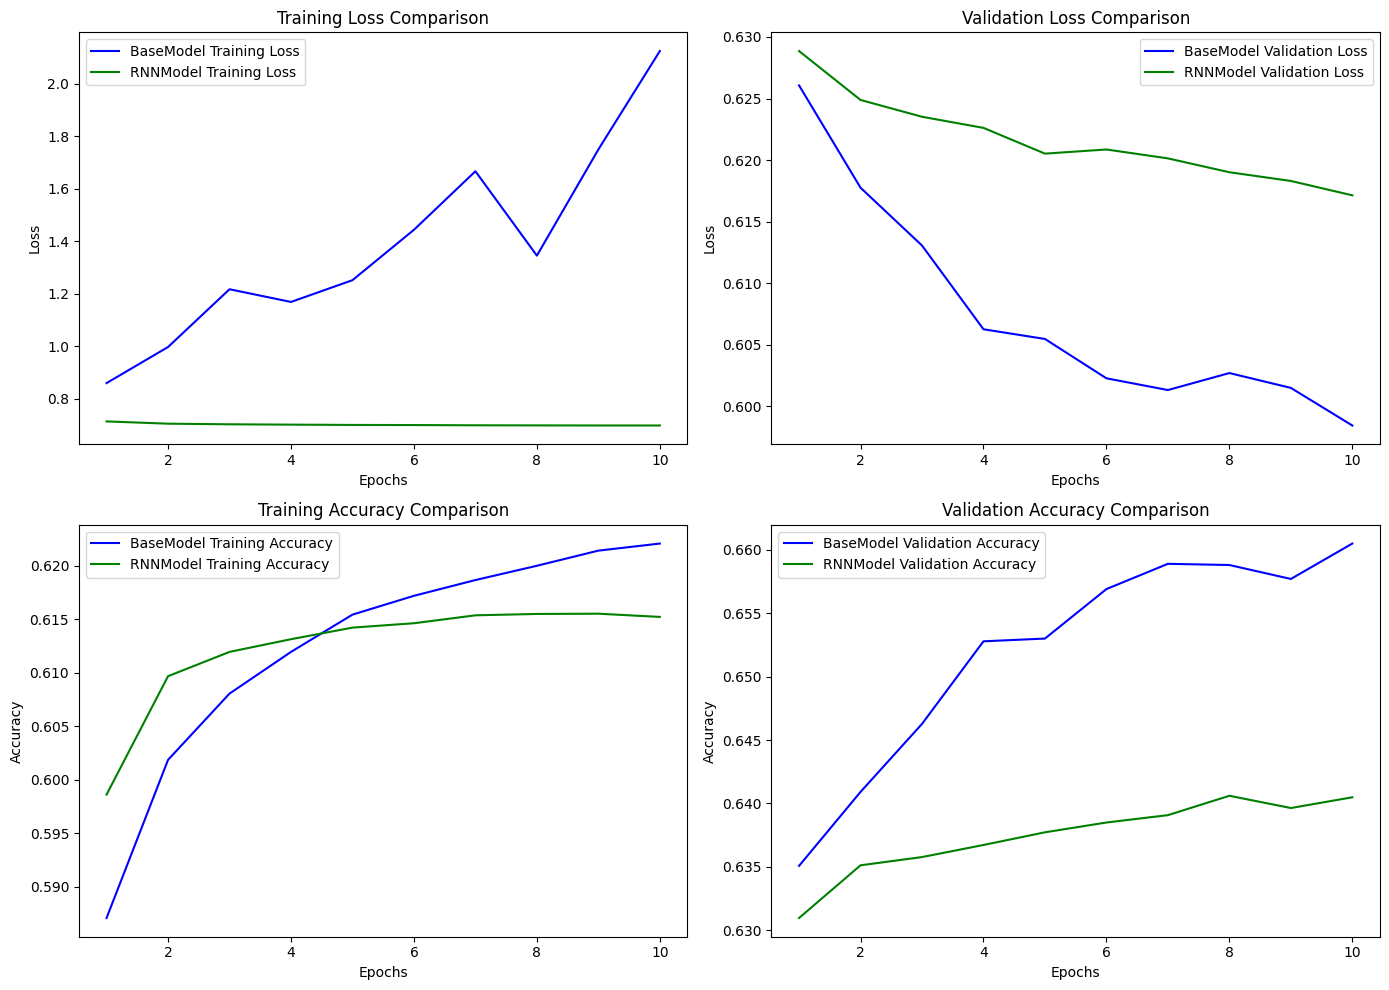

In [ ]:
import matplotlib.pyplot as plt

# Plot function for comparison between BaseModel and RNNModel
def plot_comparison(base_train_losses, base_val_losses, base_train_accuracies, base_val_accuracies,
                    rnn_train_losses, rnn_val_losses, rnn_train_accuracies, rnn_val_accuracies):

    epochs = range(1, len(base_train_losses) + 1)

    plt.figure(figsize=(14, 10))

    # Plot Training Loss Comparison
    plt.subplot(2, 2, 1)
    plt.plot(epochs, base_train_losses, 'b', label='BaseModel Training Loss')
    plt.plot(epochs, rnn_train_losses, 'g', label='RNNModel Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss Comparison
    plt.subplot(2, 2, 2)
    plt.plot(epochs, base_val_losses, 'b', label='BaseModel Validation Loss')
    plt.plot(epochs, rnn_val_losses, 'g', label='RNNModel Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Accuracy Comparison
    plt.subplot(2, 2, 3)
    plt.plot(epochs, base_train_accuracies, 'b', label='BaseModel Training Accuracy')
    plt.plot(epochs, rnn_train_accuracies, 'g', label='RNNModel Training Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy Comparison
    plt.subplot(2, 2, 4)
    plt.plot(epochs, base_val_accuracies, 'b', label='BaseModel Validation Accuracy')
    plt.plot(epochs, rnn_val_accuracies, 'g', label='RNNModel Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the comparison plot function
plot_comparison(train_losses, val_losses, train_accuracies, val_accuracies,
                rnn_train_losses, rnn_val_losses, rnn_train_accuracies, rnn_val_accuracies)
